# Integrating out the noise in Gaussian likelihood problems



A property of Gaussian likelihoods and certain is that the joint posterior distribution $p(\theta,\sigma)$ can be analytically integrated with respect to $\sigma$ to yield the marginal distribution $p(\theta)$. For example, for Gaussian log-likelihood models where we assume a prior, $\sigma\sim U(a, b),$ then the marginal posterior is given by,

$p(\theta) \propto \frac{\pi ^{-n/2} \text{sse}(\theta)^{\frac{1}{2}-\frac{n}{2}} \left[\Gamma
   \left(\frac{n-1}{2},\frac{\text{sse}(\theta)}{2 b^2}\right)-\Gamma
   \left(\frac{n-1}{2},\frac{\text{sse}(\theta)}{2 a^2}\right)\right]}{2 \sqrt{2} (b - a)}$,
   
where $\text{sse}(\theta) = \sum_{i=1}^n(f_i(\theta) - y_i)^2,$ is the sum of square errors and $\Gamma(u,v)$ is the upper incomplete gamma function.

In this notebook, we illustrate how using the posterior geometry where the noise parameter $\sigma$ is integrated out can lead to faster convergence of the posterior distribution than the circumstance where $\sigma$ is estimated.

An issue with using the integrated log-likelihood is that the estimated model is no longer generative and so posterior predictive checking is harder. Whether this is more than compensated for by the speed up of sampling from a posterior of lower dimensionality is problem specific although unlikely to considerably speed up sampling.

## Single output problem - logistic model
Here we illustrate how a posterior distribution for the logistic model growth rate and carrying capacity parameters can be estimated using both full posterior and the marginal posterior geometries.

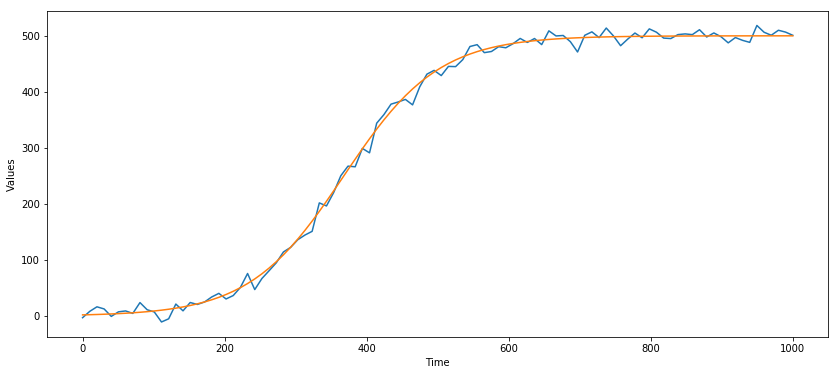

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add noise
nu = 2
sigma = 10
observed_values_norm = signal_values + scipy.stats.norm.rvs(loc=0, scale=sigma, size=signal_values.shape)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, observed_values_norm)
plt.plot(times, signal_values)
plt.show()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values_norm)

Fit the model using a Gaussian likelihood where we estimate the noise parameter $\sigma$.

Running...
Done!
R-hat:
[1.0016992148395663, 1.0018186880915745, 1.0026411227517487]


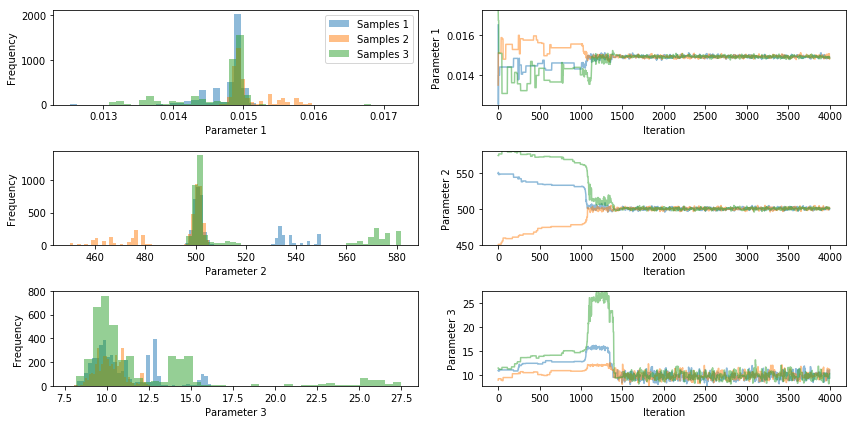

In [2]:
# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(real_parameters + [sigma])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
]


# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_gaussian = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show graphs
plt.show()

Now fitting the same model using a log-likelihood where the noise parameter $\sigma$ has been integrated out. Here the convergence to the stationary distribution is quicker.

Running...
Done!
R-hat:
[1.0003697024535547, 1.000103681856459]


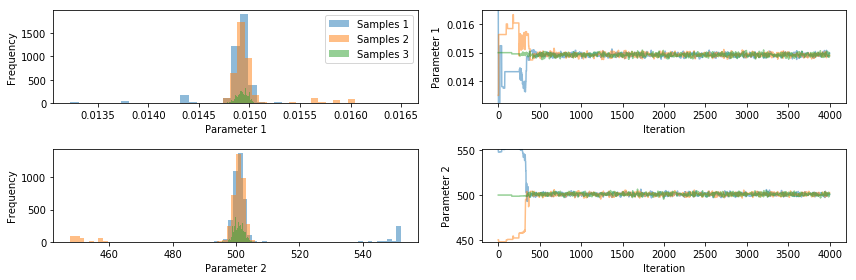

In [3]:
# Create a log-likelihood function with lower and upper values on uniform prior for sigma
lower = 1
upper = 100
log_likelihood = pints.GaussianIntegratedUniformLogLikelihood(problem, lower, upper)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array(real_parameters)
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.0,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(250)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_integrated = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show graphs
plt.show()

Comparing the marginal distributions for $r$ and $\kappa$ for the two models, they look similar.

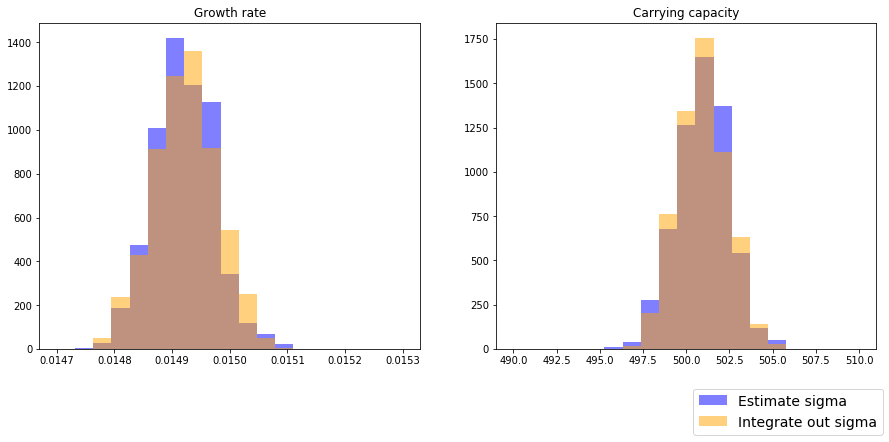

In [4]:
chains_gaussian1 = np.vstack(chains_gaussian)
chains_integrated1 = np.vstack(chains_integrated)

# plot
plt.figure(figsize=(15, 6)) 
plt.subplot(1, 2, 1)
bins = np.linspace(0.0147, 0.0153, 20)
plt.hist(chains_gaussian1[:, 0], bins, alpha=0.5, color="blue", label='Estimate sigma')
plt.hist(chains_integrated1[:, 0], bins, alpha=0.5, color="orange", label='Integrate out sigma')
plt.title("Growth rate")

plt.subplot(1, 2, 2)
bins = np.linspace(490, 510, 20)
plt.hist(chains_gaussian1[:, 1], bins, alpha=0.5, color="blue", label='Estimate sigma')
plt.hist(chains_integrated1[:, 1], bins, alpha=0.5, color="orange", label='Integrate out sigma')
plt.title("Carrying capacity")

plt.rc('font', size=14) 
plt.legend(loc="upper left", bbox_to_anchor=(0.5, -0.1))
plt.show()

## Multiple output problem - Fitzhugh-Nagumo model

Now we illustrate how to fit a Gaussian model to a problem with two outputs, where the noise has been integrated out of the likelihood.

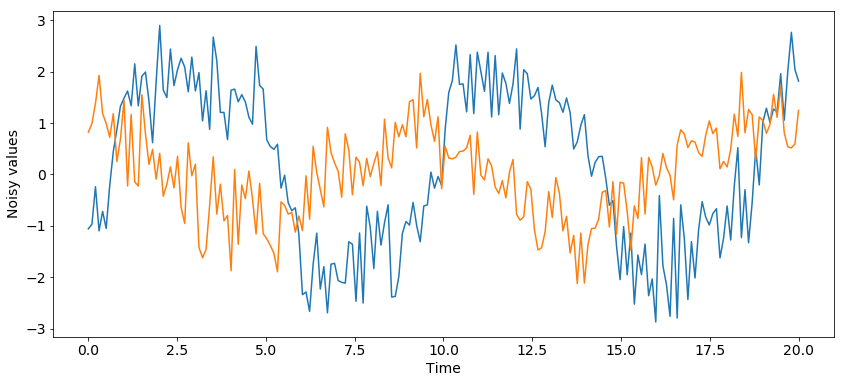

In [5]:
# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run a simulation
parameters = [0.1, 0.5, 3]
times = np.linspace(0, 20, 200)
values = model.simulate(parameters, times)

# First add some noise
sigma = 0.5
noisy = values + np.random.normal(0, sigma, values.shape)

# Plot the results
plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Noisy values')
plt.plot(times, noisy)
plt.show()

# Define a multiple output problem
problem = pints.MultiOutputProblem(model, times, noisy)

Running...
Done!
R-hat:
[1.0088230775582869, 1.0075712607521932, 1.0008015364789038, 1.0002768304474785, 1.0006504710770181]


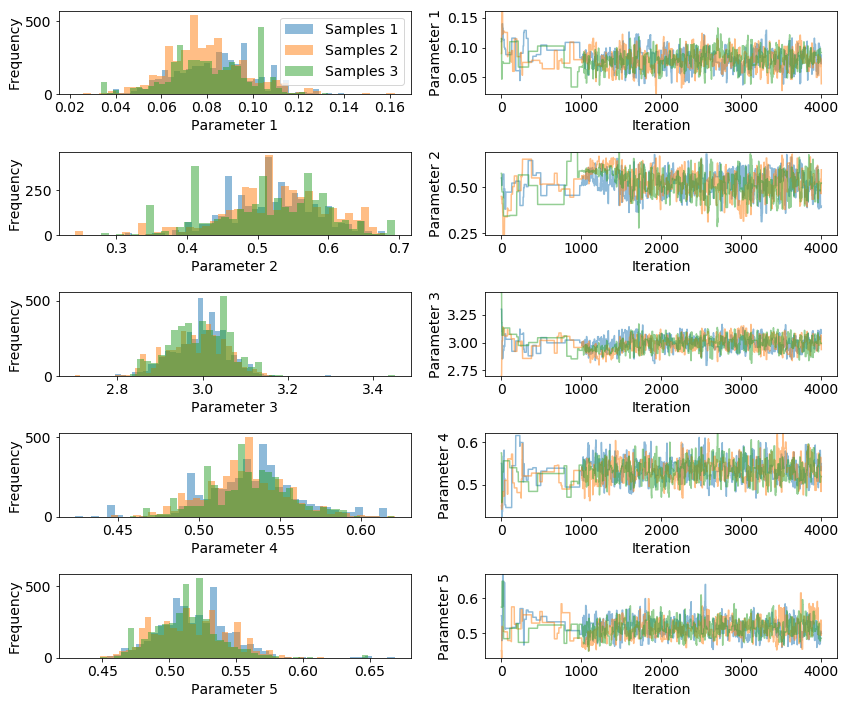

In [6]:
# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0],
    [10, 10, 10, 20, 20]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(parameters + [sigma, sigma])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_gaussian = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show graphs
plt.show()

Now estimating the same model where the two noise parameters are integrated out of the posterior. Again, the convergence rate is faster and we see much better chain mixing.

Running...
Done!
R-hat:
[1.0007486239412839, 1.0072273564630747, 1.0053885020011464]


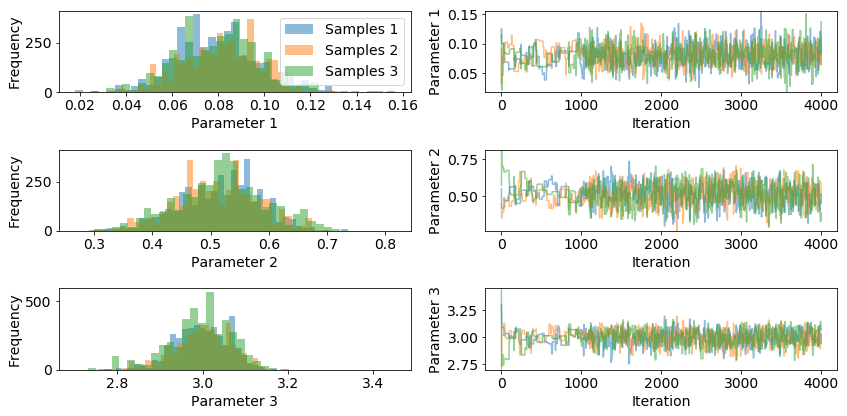

In [7]:
# Create a log-likelihood function (assumed U(0, 20) priors on both sigmas)
log_likelihood = pints.GaussianIntegratedUniformLogLikelihood(problem, 0, 20)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0],
    [10, 10, 10]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(parameters)
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_gaussian = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show graphs
plt.show()